# Exploring Spanish politicians 'distance' through their tweets (2015)

This is just a brief exploration. Even if the results are quite close to real distances between politicians, we shouldn't conclude any statistical inference from this code.

Tweets were retrieved with another python script using the library *tweepy*. I will upload the code in future.

In [1]:
#%load_ext watermark
%reload_ext watermark

%watermark -v -d -a "David Torres Pascual" -p pandas,numpy,re,nltk,string,matplotlib,seaborn,scipy,sklearn

David Torres Pascual 2016-10-04 

CPython 3.5.2
IPython 4.2.0

pandas 0.18.1
numpy 1.11.1
re 2.2.1
nltk 3.2.1
string n
matplotlib 1.5.1
seaborn 0.7.1
scipy 0.17.1
sklearn 0.18


In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords 
from nltk.stem.snowball import SpanishStemmer
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-white')
from scipy.spatial.distance import pdist,squareform
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
def readText(tweets):
    url = 'tweets//%s.txt' %tweets
    with open(url) as f: # 'r', encoding='utf-8'
        tweets = f.readlines()
        tweets = [line for line in tweets if line != '\n']
        tweets = [line for line in tweets if line != ['[...]', '(...)']]
        return tweets
        
def loadTweets(tweets):
    lista_tw = []
    for d in tweets:
        t = readText(d)
        lista_tw.append(t)
    return lista_tw

def createDF(texto):
    '''
    Install and import pandas library as you can read above
    '''    
    df = pd.DataFrame(texto)
    df_stak = df.stack().reset_index()
    del df_stak[df_stak.columns[1]]
    df_stak.columns = ['politico', 'tweets']
    return df_stak

In [4]:
tweets = ['Tgarzon', 'Tiglesias', 'Tsanchez', 'Trajoy', 'Trivera']

d = loadTweets(tweets)
df = createDF(d)
df['politico'] = tweets

In [5]:
df['tweets'] = df['tweets'].apply(lambda x: re.sub(r"http\S+", "", x))
df['tweets'] = df['tweets'].apply(lambda x: re.sub(r"@\S+", "", x))
df['tweets'] = df['tweets'].apply(lambda x: re.sub(r"RT", "", x))

stop = list(stopwords.words('spanish'))
exclude = list(string.punctuation)
exclude.extend(['¿', '¡']) 
stemmer = SpanishStemmer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(stemmer.stem(word) for word in punc_free.split())
    return normalized

df['tws_limpio'] = df['tweets'].apply(clean)

In [6]:
corpus = df['tws_limpio']
corpus.index = ['Garzón','Iglesias','Sánchez','Rajoy','Rivera']
corpus.shape

(5,)

In [7]:
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1,1))

C = vectorizer.fit_transform(corpus); C_array = C.toarray()
print(C_array.shape)
C_array

(5, 12759)


array([[0, 1, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int64)

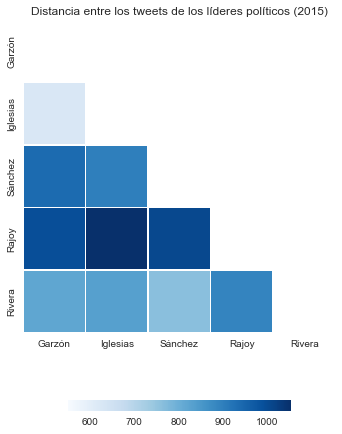

In [8]:
C_df = pd.DataFrame(C_array)
row_dist = pd.DataFrame(squareform(pdist(C_df, metric='euclidean')))

mask = np.zeros_like(row_dist)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(8,8))
ax = sns.heatmap(row_dist,
                 mask=mask,
                 square=True,
                 vmin=550,
                 #annot=True, fmt='.2f',
                 cmap='Blues', 
                 cbar=True,
                 cbar_kws={'orientation': 'horizontal', 'shrink': .5},
                 linewidths=.5,
                 robust=False,
                 xticklabels=corpus.index,
                 yticklabels=corpus.index)
ax.set(title='Distancia entre los tweets de los líderes políticos (2015)')
plt.show()